# An ablation study of the effect of of randomness in MIAs, what components are important and how they contribute to the variance of MIA predictions

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperimentSet, TargetDataset
from miae.eval_methods.prediction import Predictions

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

sns.set_context("paper")

# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

# modify this to set up directory:
DATA_DIR = "/home/data/wangz56"

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LiRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}

seeds = [0, 1, 2, 3, 4, 5]
fpr = 0.01
dataset = "cifar10"
model = "resnet56"

sns.set_context("paper")

### Here are the factors that we will consider in our ablation study:
- Shadow Model Different Initialization: 
- Number of Shadow Models
- Attack Model

### Standard experiment setup in our paper:
- Number of Shadow Models: 10 for Class-NN attack, 20 for reference attack and LiRA, 1 for difficulty calibration attack, 1 for losstraj, 1 for augmentation attack
- Shadow Model Different Initialization: True
- Attack Model: for attacks that uses attack model, we train attack model with seeds according to the attack seed, and this seed would contribute to the data shuffling and batching in the attack model optimization.

We will call this set as *standard*.

### Here are the settings that we will consider in our ablation study:
- *same_shadow_diff_attack*: for the the same attack model, we fix the shadow model used, and try train 6 different attack models based on it to see how much the randomness in attack model contributes to the variance of MIA predictions. For this experiment, we only consider the Class-NN attack, augmentation attack, Loss trajectory attack. We will compare this set to *standard*. To execute this experiment, we save the shadow model each attack at seed=0, and then train the attack model with different seeds.

- *shadow_init*: study the effect of shadow model initialization. We will compare the results of the same attack model trained on different shadow models with different initialization. We will compare this set to *standard*.

- *diff_number_shadow*: study the effect of number of shadow models. We will compare the results of the same attack model trained on different number of shadow models. We will compare this set to *standard*.


In [21]:
# Specify the experiment

exps = ["same_shadow_diff_attack", "shadow_init", "diff_number_shadow"]
exp = exps[1]

Here, we define general code that's used to compare the agreement of prediction between attack's instances. We compute the agreement of predictions between sets. 

Pair-wise Jaccard Similarity of attack $A$'s n predictions:

$$
\text{Similarity(A)} = \frac{1}{\binom{n}{2}} \sum_{i < j}  J(A_i, A_j)
$$

Where $A_x$ is the x-th instance's prediction set of attack $A$, and $J$ is the Jaccard similarity between two sets.

$$
J(A_i, A_j) = \frac{|A_i \cap A_j|}{|A_i \cup A_j|}
$$

We use the similarity as a sense of **Consistency** of attack.

Through the experiments here, we are going to use 6 instances of each attack for the pair-wise Jaccard Similarity computation.

## 1. Same Shadow Model Different Attack Model

In [22]:
if exp == 'same_shadow_diff_attack':
    attack_list = ["losstraj", "shokri", "aug"]

    output_dir = f"{DATA_DIR}/same_shadow_diff_attack"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loading dataset and predictions
    target_dataset = TargetDataset.from_dir(dataset, 
    f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

    standard_pred_dir = f"{DATA_DIR}/miae_standard_exp"
    same_shadow_diff_attack_pred_dir = f"{DATA_DIR}/same_shadow_diff_attack"

    standard_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, standard_pred_dir, seeds, model, fpr)
    same_shadow_diff_attack_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, same_shadow_diff_attack_pred_dir, seeds, model, fpr)

    # get jaccard similarity
    df = pd.DataFrame(columns=["same_shadow_models", "attack", "full_name", "jaccard_sim"]).astype({
        "jaccard_sim": float, "same_shadow_models": bool, "attack": str, "full_name": str})

    for attack in attack_list:
        jaccard_sim_standard = standard_exp_set.attack_pair_wise_jaccard_similarity(attack)
        jaccard_sim_same_shadow_diff_attack = same_shadow_diff_attack_exp_set.attack_pair_wise_jaccard_similarity(attack)

        df = pd.concat([df, pd.DataFrame([{"same_shadow_models": False, "attack": attack, "jaccard_sim": 
                jaccard_sim_standard, "full_name": mia_name_mapping[attack]},
                {"same_shadow_models": True, "attack": attack, "jaccard_sim":
                jaccard_sim_same_shadow_diff_attack, "full_name": mia_name_mapping[attack]}])], ignore_index=True)
    df.to_csv(f"{output_dir}/same_shadow_diff_attack_jaccard_sim.csv", index=False)

    # plot jaccard similarity
    fig, ax = plt.subplots()
    sns.barplot(x="full_name", y="jaccard_sim", hue="same_shadow_models", data=df, ax=ax)
    ax.set_xlabel("Attack")
    ax.set_ylabel("Jaccard Similarity")

    ax.legend(title="same shadow models", loc="upper right")
    
    
    plt.savefig(f"{output_dir}/same_shadow_diff_attack_jaccard_sim.pdf", bbox_inches='tight', format='pdf')
    print("jaccard similarity plot saved at ", f"{output_dir}/same_shadow_diff_attack_jaccard_sim.pdf")

    
        

## 2. shadow model initialization

/home/wangz56/MIAE/experiment/mia_comp/../../miae/eval_methods/prediction.py:231: RuntimeWarning: invalid value encountered in scalar divide
  return intersection / union


jaccard similarity plot saved at  /home/data/wangz56/diff_shadow_init_experiment/shadow_init_jaccard_sim.pdf


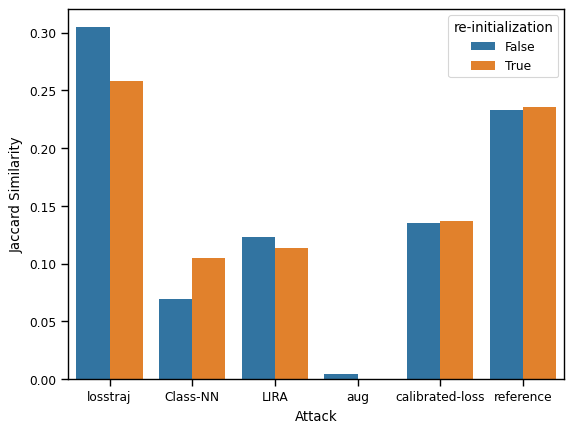

In [23]:
if exp == "shadow_init":
    attack_list = ["losstraj", "shokri", "lira", "aug", "calibration", "reference"]

    output_dir = f"{DATA_DIR}/diff_shadow_init_experiment"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loading dataset and predictions
    target_dataset = TargetDataset.from_dir(dataset, 
    f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

    diff_shadow_init_pred_dir = f"{DATA_DIR}/miae_standard_exp"

    diff_shadow_init_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_shadow_init_pred_dir,
                                                      seeds, model, fpr)
    
    same_shadow_init_pred_dir = f"{DATA_DIR}/miae_standard_exp_fix_shadow_init"

    same_shadow_init_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, same_shadow_init_pred_dir,
                                                        seeds, model, fpr)

    # get jaccard similarity
    df = pd.DataFrame(columns=["shadow_model_diff_init", "attack", "full_name", "jaccard_sim"]).astype({
        "jaccard_sim": float, "shadow_model_diff_init": bool, "attack": str, "full_name": str})

    for attack in attack_list:
        jaccard_sim_diff_shadow_init = diff_shadow_init_exp_set.attack_pair_wise_jaccard_similarity(attack)
        jaccard_sim_same_shadow_init = same_shadow_init_exp_set.attack_pair_wise_jaccard_similarity(attack)

        df = pd.concat([df, pd.DataFrame([{"shadow_model_diff_init": True, "attack": attack, "jaccard_sim": 
                jaccard_sim_diff_shadow_init, "full_name": mia_name_mapping[attack]},
                {"shadow_model_diff_init": False, "attack": attack, "jaccard_sim":
                jaccard_sim_same_shadow_init, "full_name": mia_name_mapping[attack]}])], ignore_index=True)
    df.to_csv(f"{output_dir}/shadow_init_jaccard_sim.csv", index=False)

    # plot jaccard similarity
    fig, ax = plt.subplots()
    sns.barplot(x="full_name", y="jaccard_sim", hue="shadow_model_diff_init", data=df, ax=ax)
    ax.set_xlabel("Attack")
    ax.set_ylabel("Jaccard Similarity")

    ax.legend(title="re-initialization", loc="upper right")
    
    plt.savefig(f"{output_dir}/shadow_init_jaccard_sim.pdf", bbox_inches='tight', format='pdf')
    print("jaccard similarity plot saved at ", f"{output_dir}/shadow_init_jaccard_sim.pdf")
    


## 3. different number of shadow models

In [24]:
lira_shadow_num_shadow_models = [20, 40, 60, 80, 100]
calibration_num_shadow_models = [1, 3, 5, 10]

if exp == "diff_number_shadow":
    
